# Prediction models for 2017 College Rankings

I will be creating and analyzing prediction models on <a href='https://en.wikipedia.org/wiki/Times_Higher_Education'> Time Higher Education</a>'s top 200 world universities for one of my beginner's project. I will be using the data from the 2016 subset to predict rankings for 2017. The regression methods I will be utilizing are Random Forest, Ridge Regression, Linear Regression, and KNN (k=5). I will compare each of the model and offer an interpretation of the results.

The dataset and its description can be found on <a href='https://www.kaggle.com/mylesoneill/world-university-rankings'> Kaggle</a>, and I'll be using the dataset as downloaded on July 22nd.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# Fix this line
data = pd.read_csv('csvfilehere')

## Glancing over the dataset

Since the dataset includes rankings from 2011 to 2016, we will have to filter the 2016 rankings for usage. From the 2016 ranking we will create a dataframe of the top 200 universities to get a good overview. Although the dataset is clean, some tidying is still necessary such as the datatypes.

In [2]:
data.dtypes

world_rank                 object
university_name            object
country                    object
teaching                  float64
international              object
research                  float64
citations                 float64
income                     object
total_score                object
num_students               object
student_staff_ratio       float64
international_students     object
female_male_ratio          object
year                        int64
dtype: object

Above we can see that **international**, **income**, and **total_score** must be converted into a float. 

After cleaning this dataframe, we will create a new one with only the predictors and response variables. In the analysis our key features are **teaching**, **international**, **research**, **citations**, and **income**.

In [6]:
# Select only the top 200 colleges from the year 2016
uni = data[data['year'] == 2016]
uni = uni[:200] # Our dataset is alrady sorted by rank

# Fix world ranking having '=' as values
uni['world_rank'] = uni['world_rank'].str.replace("=", "")

# Keeping only relevant columns for first dataframe
columns_to_keep = ['world_rank', 'university_name', 'country','teaching', 'international', 'research', 'citations', 'income', 'total_score']
uni = uni[columns_to_keep]

# Fix the index
uni.index = np.arange(1, len(uni)+1)
# The reason we don't use the world_rank as the index is because its numbering
# becomes faulty near the end

# Change international, total_score, and income into float types
uni['total_score'] = uni['total_score'].convert_objects(convert_numeric=True)
uni['international'] = uni['international'].convert_objects(convert_numeric=True)

uni['income'] = uni['income'].str.replace("-", "") # This will create NA values
uni['income'] = uni['income'].convert_objects(convert_numeric=True)
uni['income'].fillna(round(uni['income'].mean(), 1), inplace=True)

uni.head(7)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,world_rank,university_name,country,teaching,international,research,citations,income,total_score
1,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.2
2,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.2
3,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.9
4,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8
5,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,92.0
6,6,Harvard University,United States of America,83.6,77.2,99.0,99.8,45.2,91.6
7,7,Princeton University,United States of America,85.1,78.5,91.9,99.3,52.1,90.1


Just to reassure ourselves that everything is okay, we can check the count.

In [7]:
uni.describe()

,teaching,international,research,citations,income,total_score
count,200.00000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,50.25000,66.789000,53.905500,82.91500,56.120000,62.520000
std,16.28864,19.601097,19.765154,12.79835,22.858125,12.040555
min,25.00000,26.100000,18.100000,8.60000,28.000000,48.800000
25%,38.50000,51.650000,39.000000,76.67500,36.775000,52.900000
50%,47.40000,64.700000,48.650000,84.70000,49.550000,57.950000
75%,59.95000,84.575000,69.375000,92.20000,72.400000,69.625000
max,95.60000,99.800000,99.000000,100.00000,100.000000,95.200000


The count sums to 200 just as we wanted! From a look at the quick statistics, one can conclude several ideas.

First, a minimum total score of 48.8 is needed to rank in the top 200 (as reference, there is a total of 800 universities ranked in 2016).

Second, the median total score is 57.95. I was surprised since I was expecting about 65.0 or 70.0, but the third quantile is 69.62. So at that 75% mark, there is a relatively large gap dividing the top 50 universities from the other 150 schools.

Third, the top ranked university does not have all the maxed values of the features. Caltech's teaching value is the only value that matches one of the five feature's max value. I guess this is logical, since each university is unique in its circumstances and its limitations. 

Of course we removed some features from the original dataset for the sake of this analysis, but I was expecting these features to have a greater impact on the sccore. To expand on this thought, adding the feature values directly doesn't give a cookie-cutter explanation on how the universities are ranked. For example, adding MIT's values give 457.1, but Harvard and Princeton score a sum of 404.8 and 406.9 respectively. Despite this difference, the total score only increased minutely. So, the unincluded features can be said to have a large influence on the total score, but we'll continue to use our selected predictors instead.

So let's check how correlated our variables are with one another.

In [8]:
uni.corr()

,teaching,international,research,citations,income,total_score
teaching,1.000000,-0.043388,0.894834,0.186377,0.201191,0.909918
international,-0.043388,1.000000,0.057884,0.063861,-0.072871,0.151108
research,0.894834,0.057884,1.000000,0.150736,0.257712,0.923236
citations,0.186377,0.063861,0.150736,1.000000,-0.220625,0.466585
income,0.201191,-0.072871,0.257712,-0.220625,1.000000,0.177021
total_score,0.909918,0.151108,0.923236,0.466585,0.177021,1.000000


A good guess for later is that **teaching**, **research**, and **citations** will impact our regression coefficients the most. One important fact is that **teaching** and **research** are *highly correlated* with one another and exhibits *collinearity*. If we were to to use them as individual predictors for its impact on the total score, it would give poor results. Otherwise, it is okay to use them together with the other predictor variables in determining the outcome variable. Still, I would expect that they might impact our models.

## Building our model for prediction analysis

Let's create the new dataframe composed of only the features and the response. Then we'll separate the data into a training and test set.

In [9]:
# Dataframe with only features and the response
uniset = uni.drop(['world_rank', 'university_name', 'country'], axis=1)
uniset.head(3)

,teaching,international,research,citations,income,total_score
1,95.6,64.0,97.6,99.8,97.8,95.2
2,86.5,94.4,98.9,98.8,73.1,94.2
3,92.5,76.3,96.2,99.9,63.3,93.9


In [10]:
# Split the dataset into a training and test set
X = uniset.drop('total_score', axis=1)

# For our analysis we will split 60% for training and 40% for testing,
# since we have a small number of samples
X_train, X_test, Y_train, Y_test = train_test_split(X, uniset['total_score'], test_size=0.40, random_state=32)

# Let's check to make sure it split well
print('X train: ', X_train.shape)
print('Y train: ', Y_train.shape)
print('X test: ', X_test.shape)
print('Y test: ', Y_test.shape)

X train:  (120, 5)
Y train:  (120,)
X test:  (80, 5)
Y test:  (80,)


With the dataset now separated into a testing and test set, let's begin creating our models. It is important that when we run the prediction and check its test results, we shouldn't necessarily try to tune our model anymore in order to match the test result. If we did, we would just be overfitting our test set, and failing to build a model for future instances. 

In [11]:
# Build and save our prediction models 
model_forest = RandomForestRegressor(n_estimators=300, n_jobs=-1) # 300 trees
model_ridge = Ridge(alpha=0.3) # Penalty of 0.3
model_linear = LinearRegression()
model_knn = KNeighborsRegressor(n_neighbors=5) # k=5

model_list = [model_forest, model_ridge, model_linear, model_knn]
model_yhat = [[], [], [], []]
count = 0 # Using dictionaries would not allow for easier calculations later, so we are using a list of lists and appending it
rsquared_list = []
MSE_list = []

# Fit the model, use it to predict the total scores, and then get the R^2 and MSE
for model in model_list:
    model.fit(X_train, Y_train)
    model_yhat[count].append(model.predict(X_test))
    count +=1
    rsquared_list.append(model.score(X_test, Y_test))
    MSE_list.append(mean_squared_error(Y_test, model.predict(X_test)))

# Create a dataframe to look at the results
stat_info = {'R^2' : rsquared_list, 'MSE' : MSE_list}
model_table = pd.DataFrame(stat_info, columns=['R^2', 'MSE'],
                           index=['Random Forest', 'Ridge', 'Linear', 'KNN'])
model_table

,R^2,MSE
Random Forest,0.943947,8.936911
Ridge,0.999832,0.026773
Linear,0.999832,0.026775
KNN,0.950399,7.908175


## Looking at the results

### Ridge and Linear

I am very skeptical on the Ridge and Linear Regression. A MSE close to 0 and R^2 close to 1.0 is too perfect, and suggests the possibility of overfitting or a poor choice of model. 

Although ridge regression tackles variables with high collinearity with its penalty term, it works best with **many** features in the dataset. In our case, only 5 independent variables were used in the model. Unlike lasso, ridge regression does not perform feature selection (i.e. making the least impacting features 0) and will keep all the features in its usage. So I chose ridge regression to use over lasso. Another point is that our 2016 dataframe possesses a lack of data to work on (120 training values). For our linear regression model, The linear regression suffers from being a basic model and possibly overfitting.

### Random Forest

This model looks more realistic, and its R^2 value isn't terrible. Since it's a good measure, let's use it to check each feature's importance. Note that we are unable to check coefficients because of how random forest is performed.

teaching         0.484159
research         0.430823
citations        0.064866
international    0.011739
income           0.008412
dtype: float64


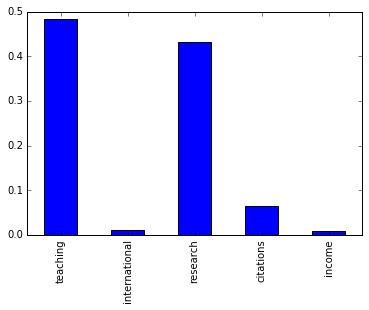

In [12]:
# Get feature importance and plot it
model_forest.feature_importances_
feat_imp = pd.Series(model_forest.feature_importances_, index=X.columns)
feat_imp.plot(kind="bar")
print(feat_imp.sort_values(ascending=False))

As we've guessed previously, **teaching**, **research**, and **citations** have the highest effect on the total score in our dataset. Random Forest did a pretty great job for our dataset in handling these correlated variables, but KNN did an even better job.

### K-nearest Neighbors
We could've picked any k value, but I just chose 5. Still, the R^2 value is greater and the MSE is lower than those of random forest. Both of these two models are certainly more believable considering the fact that we excluded some variables.

Let's check the residual plots for the KNN model. The residual plots created will have the residuals on the y-axis, and the fitted values on the x-axis. Due to software limitations, we are unable to use all the predictors for designing a 3-D plot. Instead we'll use just plot each individual predictor against the residuals. We should not expect great plots despite the believable R^2 and MSE values. This belief is because of the high collinearity of **teaching** and **research**, the exclusion of many other features in influencing the residuals, and the MSE being large.

In [14]:
# Make the observed values into an array
Y_test = np.array(Y_test)

residuals = [] 

# For reference, the order of the residuals are 
# Random Forest, Ridge, Linear, and then KNN
# Calculates our residuals
for array in model_yhat:
    temp = np.array(array)
    residuals.append(Y_test - temp) #Add the arrays as a new list

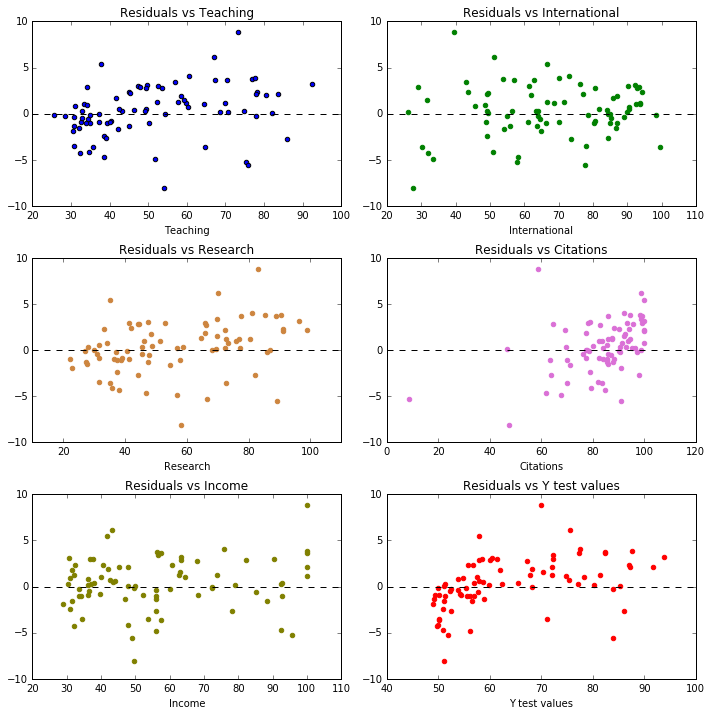

In [15]:
# Create our residual plots
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# Teaching
ax1.scatter(X_test['teaching'],residuals[3][0])
ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_title('Residuals vs Teaching')
ax1.set_xlabel('Teaching')

# International
ax2.scatter(X_test['international'],residuals[3][0], color='green')
ax2.axhline(y=0, color='k', linestyle='--')
ax2.set_title('Residuals vs International')
ax2.set_xlabel('International')

# Research
ax3.scatter(X_test['research'],residuals[3][0], color='peru')
ax3.axhline(y=0, color='k', linestyle='--')
ax3.set_title('Residuals vs Research')
ax3.set_xlabel('Research')

# Citations
ax4.scatter(X_test['citations'],residuals[3][0], color='orchid')
ax4.axhline(y=0, color='k', linestyle='--')
ax4.set_title('Residuals vs Citations')
ax4.set_xlabel('Citations')

# Income
ax5.scatter(X_test['income'],residuals[3][0], color='olive')
ax5.axhline(y=0, color='k', linestyle='--')
ax5.set_title('Residuals vs Income')
ax5.set_xlabel('Income')

# Y_test
ax6.scatter(Y_test,residuals[3][0], color='red')
ax6.axhline(y=0, color='k', linestyle='--')
ax6.set_title('Residuals vs Y test values')
ax6.set_xlabel('Y test values')

fig.tight_layout()

True enough, our plots aren't too great for several reasons.

Firstly, there are a lot of outliers within each plot. Yes, it's each predictor variable being plotted against the residuals, but we should not be seeing that many outliers! For instance, the citation residual plot exhibit one of the outliers to the far left (underpredicted by a lot) and another up top (overpredicted by a lot). One explanation is that the values at these points are very uncommon compared to the rest of the column's values.

Another fault can be seen directly on the Residual vs Y test values plot. The plot should be showing a more positive correlation! Instead, it looks almost flat. 

In additon, I would argue that the residual plots exhibit vague patterns. Most of the points are overpredicting and often stay in the positive level. This can indicate some heavy bias, but of course there isn't too much variability within our columns' values.

If we were to plot the residuals for the other models, we would most likely discover they would also perform poorly.

## Conclusion

Our models performed very poorly. Although our best model exhibited a decent R^2 value, its MSE is very high and contributed to overpredicting and underpredicting as visualized in the residual plots. Our model is not doing a great job of predicting values, despite its believability compared to the rest of the other models. 

Regardless of our faulty modeling, we can probably guess that a university's score is heavily influenced by its teaching value and number of researches. One interesting note is that citations have a stronger influence than international score in this particular model. My guess is that having more citations represent higher credibility and give rise to expansion within the academic fields. This is what Times may support in its real model. Still, the features that we **did** exclude were mainly on diversity. If our models have been doing poorly, it can be safe to say that diversity has a strong impact on the total score calculations.

An improved model of this dataset will have all or most of the features included. That way, it can reduce the heavy bias seen within the model. Also we could try using more trees in our random forest, and it could help. We can also try increasing k in our nearest neighbor, but we have to be more skeptical about any overfitting issues. Another way to improve our model is to use past years along with the 2016 data to aid in the prediction. More samples will certainly help.

Hope you enjoyed one of my beginner projects!